In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
from Corrfunc.theory import DD
from Corrfunc.utils import convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import tools

### load TNG snapshot, compute 3D galaxy autocorrelation (from pair counts, Corrfunc), and compare to linear theory, for a few different redshifts

In [3]:
# INPUT PARAMETERS

# TNG snapshots
snapshots = [33, 40, 63, 67, 72, 80]
# redshift error (this determines the target number density in the spectroscopic galaxy sample)
sigma_z = 0.1  # one of the 5 redshift error bins in SPHEREx
# for Corrfunc (same bins as in alternative_limber_formula20240117.ipynb for a direct comparison)
randmult = 3
rmin = 0.1
rmax = 60
nbins = 10
nthreads = 10
periodic = False
nrepeats = 5  # how many times to repeat computation to help with noise / numerical errors ?

snapshot 33
 number density for SPHEREx at z=2.0: 7.75e-05 (h/Mpc)^3 
target number of subhalos: 667
shifting data by L/2!


/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/work/08811/aew492/frontera/small-scale_cross-corrs/photxspec.py:229: RuntimeWarning: Mean of empty slice
  bias = np.nanmean(ratio[bias_range[0]:bias_range[1]])


snapshot 40
 number density for SPHEREx at z=1.5: 7.96e-04 (h/Mpc)^3 
target number of subhalos: 6857
shifting data by L/2!
snapshot 63
 number density for SPHEREx at z=0.6: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
shifting data by L/2!
snapshot 67
 number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
shifting data by L/2!
snapshot 72
 number density for SPHEREx at z=0.4: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
shifting data by L/2!
snapshot 80
 number density for SPHEREx at z=0.26: 1.29e-02 (h/Mpc)^3 
target number of subhalos: 111135
shifting data by L/2!


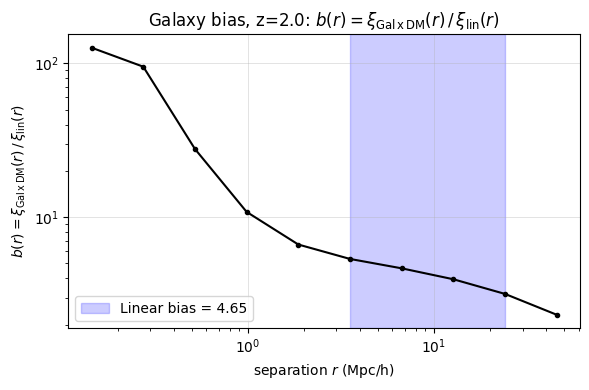

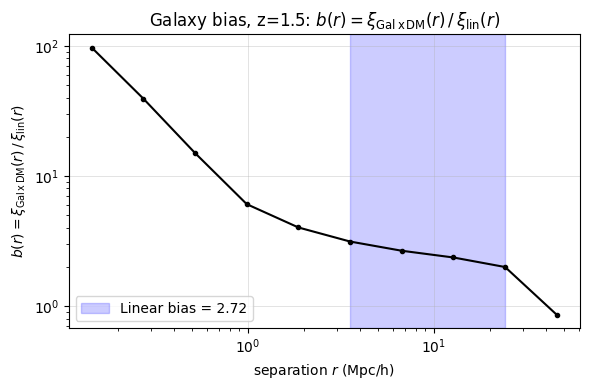

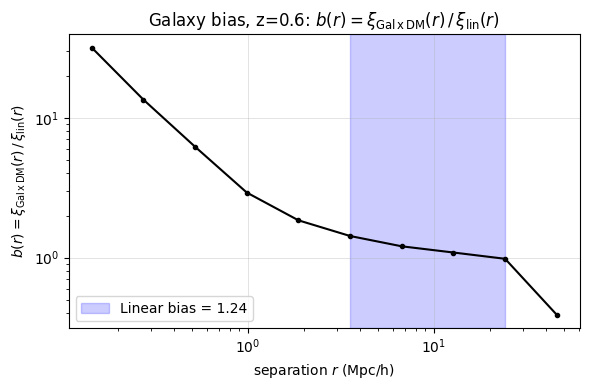

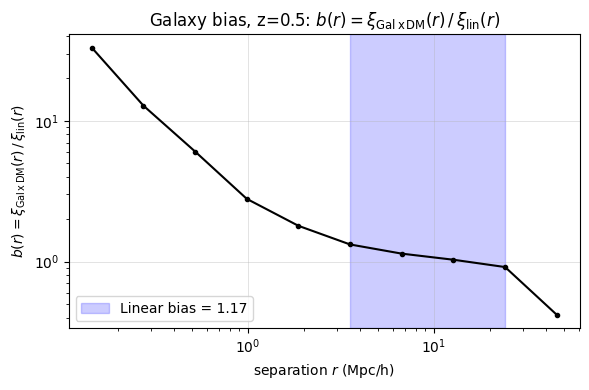

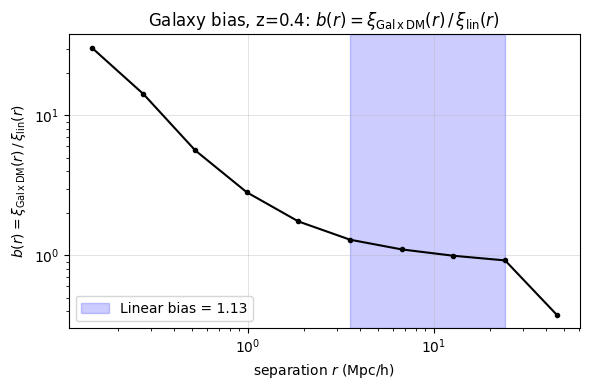

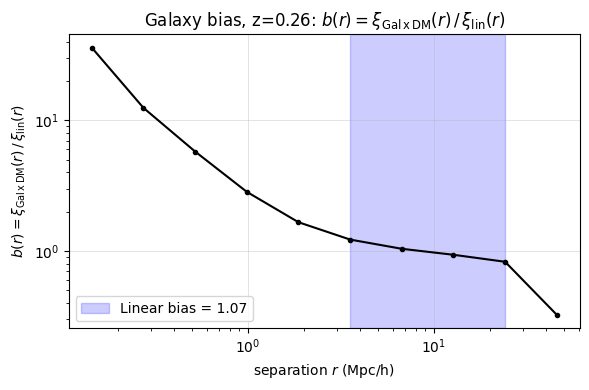

In [4]:
# loop through each snapshot, saving the Corrfunc and linear theory autocorrelation functions

redshifts = np.empty(len(snapshots))
xis_paircounts = np.empty((len(snapshots), nbins))
xis_linear = np.empty_like(xis_paircounts)

for i, snapshot in enumerate(snapshots):
    print(f"snapshot {snapshot}")

    # load the snapshot:
    
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    # comoving distance to the box center
    chi = tools.redshift_to_comov(sim.redshift)
    # construct spectroscopic galaxy sample from the TNG subhalos
    gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
    # shift to center at zero
    gal_pos_spec -= sim.boxsize / 2
    
    
    # compute the pair counts:

    # prep data
    data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rmin, rmax=rmax, nbins=nbins,
                                      boxsize=sim.boxsize, logbins=True)
    r_edges, r_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
    assert np.allclose(boxsize, sim.boxsize.value)
    assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
    assert np.all(data_set >= 0) and np.all(data_set <= boxsize)

    # unpack
    xd, yd, zd = data_set.T
    xr, yr, zr = rand_set.T

    xis = np.full((nrepeats,nbins), np.nan)

    for j in range(nrepeats):

        dd_res = DD(1, nthreads, r_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_ravg=True)
        dr_res = DD(0, nthreads, r_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
        rr_res = DD(1, nthreads, r_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

        # turn pair counts into actual correlation function: Landy-Szalay estimator
        xis[j] = convert_3d_counts_to_cf(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res)

    xi = np.nanmean(xis, axis=0)  # get the mean across the runs
    
    # compare to linear theory
    xi_lin_dm = tools.linear_2pcf(sim.redshift, r_avg)

    # get linear bias from spectroscopic sample
    _, ratio = photxspec.get_linear_bias(gal_pos_spec, sim, r_edges=r_edges, return_ratio=True)

    # range to compute linear bias
    biasrange = (-5,-2) # indices from ravg
    bias = np.mean(ratio[biasrange[0]:biasrange[1]])
    
    # plot
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    ax.plot(r_avg, ratio, 'k.-')
    ax.axvspan(r_avg[-5], r_avg[-2], color='b', alpha=0.2, label=f'Linear bias = {bias:.2f}')
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.set_ylabel(r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$')
    ax.set_title(f'Galaxy bias, z={sim.redshift}: 'r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$')
    ax.legend()
    
    # galaxy c.f. is the matter c.f. times the bias squared
    xi_lin = bias**2 * xi_lin_dm
    
    # save the results for this snapshot
    redshifts[i] = sim.redshift
    xis_paircounts[i] = xi
    xis_linear[i] = xi_lin

Text(0.5, 1.0, '3D galaxy autocorrelations compared to linear theory')

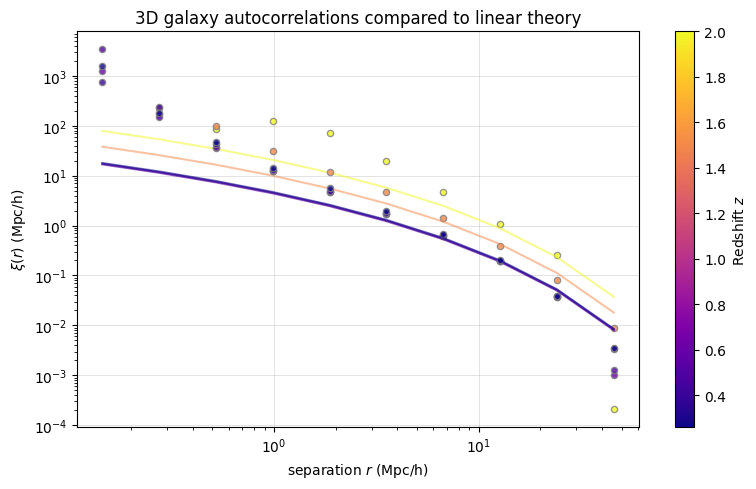

In [5]:
# compare the autocorrelation functions
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, redshift in enumerate(redshifts):
    ax.plot(r_avg, xis_paircounts[i], marker='.', ms=9, mec='grey', ls='None', lw=0.5, alpha=0.8, c=smap.to_rgba(redshift))
    ax.plot(r_avg, xis_linear[i], ls='-', alpha=0.5, c=smap.to_rgba(redshift))
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$ (Mpc/h)')
fig.colorbar(smap, ax=ax, label=r'Redshift $z$')
ax.set_title('3D galaxy autocorrelations compared to linear theory')